# Projeto 2-2: Contagem de Pessoas

### Guilherme Zaborowsky Graicer

**Motivação**: http://www.cvg.reading.ac.uk/PETS2009/a.html#s1

Objetivo: Vocês devem tentar realizar a contagem de pessoas no dataset S1.L1 utilizando o modelo de codebook. As imagens foram distribuídas via pendrive.

Requisitos:
  * Tem que usar o modelo de codebook do artigo.
  * A partir da separação do foreground, vocês podem utilizar qualquer método para realizar a contagem, incluindo Clustering ou Machine Learning.
  * O Repositório no Git deve conter além do código fonte, os dados do codebook treinado salvo com Pickle e um relatório do projeto.
  * O relatório deve conter a metodologia utilizada (incluindo treinamento) e comentário sobre os resultados obtidos.


In [1]:
%reset -f
%matplotlib inline

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os

## O Treinamento

Para treinar o programa para saber o que é o background usou-se a técnica de Codewords, descrita com detalhes no artigo "Real-time foreground–background segmentation using codebook model". Nele passa-se por um número de imagens construindo um codebook para cada pixel no tempo. Uma codeword foi implementada com uma classe com 2 atributos: um vetor representando sua cor em RGB, e outro (aux) com os valores de mínimo e máximo de brilho, frequencia, o maior intervalo em que esse codeword nao aparece, a primeira e a ultima vez que ele aparece.

### Construindo os Codebooks

Primeiramente é criada uma matrix de codebooks vazios das dimenções da imagem. Ao percorrer os pixels de cada imagem, é observado se eles se encaixam em alguma codeword existente no codebook correspondente, se não cria-se uma nova e adiciona-se ao codebook. A comparação do pixel com a codeword baseia-se na distância de cor (checa se ela é menor que uma constante escolhida, epsilon) e num intervalo de brilho.

Após a construção inicial do codebook, faz-se um ajuste no lambda (maior intervalo em que esse codeword nao aparece) como feito no artigo. Por fim, a matriz passa por um filtro temporal, onde, usando o lamdba, elimina-se as codewords que aparecem pouco.



In [2]:
class codeword:
    def __init__(self, r, g, b, i_min, i_max, f, lambida, p, q):
        self.rgb = [r,g,b]
        self.aux = [i_min, i_max, f, lambida, p, q]

e1 = 120 #12
e2 = 120 #8
beta = 1.1 #typically entre 1.1 and 1.5
alpha = 0.4 # typically entre 0.4 and 0.7

#Calcula a distancia de cor entre um pixel e um codeword
def color_dist(x, v):
    x2 = (x[0]**2) + (x[1]**2) + (x[2]**2)
    v2 = (v[0]**2) + (v[1]**2) + (v[2]**2)
    xv2 = ((v[0]*x[0]) + (v[1]*x[1]) + (v[2]*v[2]))**2
    if v2 == 0:
        p2 = 0
    else:
        p2 = xv2 / v2
    
    return np.sqrt(abs(x2 - p2))

# Retorna True se a intensidade do pixel (I) está aceitavel para um codeword
# com certa intensidade minima e maxima (Imin e Imax). Retorna False caso contrário.
def bright(I, Imin, Imax):
    Ilow = Imax*alpha
    Ihi = min((beta*Imax),(Imin/alpha))
    if I <= Ihi and I >= Ilow:
        return True
    return False
    
#funcao para o treinamento, cria e atualiza codewords da matriz de codebooks
def codebook_update(x, codebook, t):
    achou = False
    I = np.sqrt((x[0]**2)+(x[1]**2)+(x[2]**2))
    for c in codebook:
        cd = color_dist(x, c.rgb)
        if ((cd <= e1) and (bright(I, c.aux[0], c.aux[1]))):
            achou = True
            # ATUALIZA A CODEWORD
            r_new = ((c.aux[2]*c.rgb[0])+x[0])/(c.aux[2]+1)
            g_new = ((c.aux[2]*c.rgb[1])+x[1])/(c.aux[2]+1)
            b_new = ((c.aux[2]*c.rgb[2])+x[2])/(c.aux[2]+1)
            c.rgb = [r_new, g_new, b_new]
            c.aux = [min(I, c.aux[0]), max(I, c.aux[1]), (c.aux[2]+1), max(c.aux[3], (t-c.aux[5])), c.aux[4], t]
            break
    if achou == False:
        #CRIA NOVO CODEWORD
        c_new = codeword(x[0], x[1], x[2], I, I, 1, t-1, t, t)
        codebook.append(c_new)
        

# funcao para a subtração de background, checka se o pixel da match no codebook
def codebook_check(x, codebook):
    achou = False
    I = np.sqrt((x[0]**2)+(x[1]**2)+(x[2]**2))
    for c in codebook:
        cd = color_dist(x, c.rgb)
        if ((cd <= e2) and (bright(I, c.aux[0], c.aux[1]))):
            achou = True
            # ATUALIZA A CODEWORD
            r_new = (c.aux[2]*c.rgb[0]+x[0])/(c.aux[2]+1)
            g_new = (c.aux[2]*c.rgb[1]+x[1])/(c.aux[2]+1)
            b_new = (c.aux[2]*c.rgb[2]+x[2])/(c.aux[2]+1)
            c.rgb = [r_new, g_new, b_new]
            c.aux = [min(I, c.aux[0]), max(I, c.aux[1]), (c.aux[2]+1), max(c.aux[3], (1-c.aux[5])), c.aux[4], 1]
            break
            
    return achou
    
def create_matrix(rows, cols):
    m = []
    for i in range(rows):
        m.append([])
        for j in range(cols):
            m[i].append([])
    return m
        

In [3]:


codebook_matrix = None

T = 15

directory1 = "../img/Crowd_PETS09/S0/Background/View_001/Time_13-19/"
images1 = os.listdir(directory1)
# print(images1)

for t in tqdm(range(1,(T+1)), unit="Image"):
#     img = cv.imread(("../img/Crowd_PETS09/S0/Background/View_001/Time_13-06/00000036.jpg"))
    img = cv.imread(directory1 + images1[t], 1)
    rows, cols, cor = img.shape
    
    # se for a 1a vez do loop, cria a matriz vazia de codebooks
    if t == 1:
        codebook_matrix = create_matrix(rows, cols)
    
    for j in range(cols):
        for i in range(rows):
            codebook_update(img[i][j].astype(float), codebook_matrix[i][j], t)
    
# ajusta o lambida
for j in range(cols):
    for i in range(rows):
        cb = codebook_matrix[i][j]
        for c in cb:
            c.aux[3] = max(c.aux[3], (T-c.aux[5]+c.aux[4]-1))
            

            
    

100%|██████████| 15/15 [02:03<00:00,  8.16s/Image]


In [4]:
arq = open("codebook_salvo1.pickle", "wb")
pickle.dump(codebook_matrix, arq)
arq.close()

In [5]:
qtos = []
for j in range(cols):
    for i in range(rows):
        cb = codebook_matrix[i][j]
        qtos.append(len(cb))
        
for i in range(1,(T+1)):      
    print("Codebooks com " + str(i) + " words: " + str(qtos.count(i)))

Codebooks com 1 words: 274659
Codebooks com 2 words: 158314
Codebooks com 3 words: 8960
Codebooks com 4 words: 415
Codebooks com 5 words: 20
Codebooks com 6 words: 0
Codebooks com 7 words: 0
Codebooks com 8 words: 0
Codebooks com 9 words: 0
Codebooks com 10 words: 0
Codebooks com 11 words: 0
Codebooks com 12 words: 0
Codebooks com 13 words: 0
Codebooks com 14 words: 0
Codebooks com 15 words: 0


In [7]:
Tm = T / 2

# Aplicando o filtro temporal

for j in range(cols):
    for i in range(rows):
        cb = codebook_matrix[i][j]
        cb_new = []
        for c in cb:
            if c.aux[3] <= Tm:
                cb_new.append(cb[cb.index(c)])
        
        codebook_matrix[i][j] = cb_new
            

In [8]:
qtos = []
for j in range(cols):
    for i in range(rows):
        cb = codebook_matrix[i][j]
        qtos.append(len(cb))
        
print("Contgem pós-filtro\n")
for i in range(1,(T+1)):      
    print("Codebooks com " + str(i) + " words: " + str(qtos.count(i)))

Contgem pós-filtro

Codebooks com 1 words: 411340
Codebooks com 2 words: 30806
Codebooks com 3 words: 209
Codebooks com 4 words: 0
Codebooks com 5 words: 0
Codebooks com 6 words: 0
Codebooks com 7 words: 0
Codebooks com 8 words: 0
Codebooks com 9 words: 0
Codebooks com 10 words: 0
Codebooks com 11 words: 0
Codebooks com 12 words: 0
Codebooks com 13 words: 0
Codebooks com 14 words: 0
Codebooks com 15 words: 0


## Subtração de Background

Com o treinamento feito, já é possivel identificar coisas que não fazem parte do background na imagem (como pessoas por exemplo). Para isso foi usado uma imagem toda preta na resolução da imagem original, e para cada pixel que nao tivesse uma codeword correspondente em seu codebook, pintou-se de branco. O resultado fica o background preto e o foreground branco.

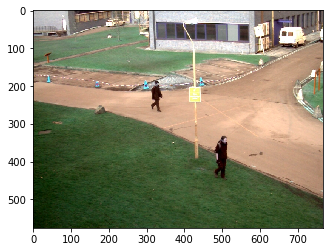

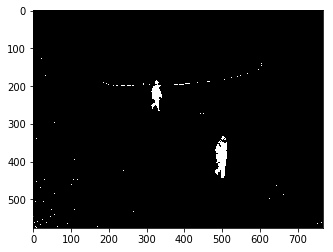

In [25]:
#Teste com 1 imagem de foreground

img_teste = cv.imread(("../img/Crowd_PETS09/S0/Background/View_001/Time_13-19/00000172.jpg"))



rows, cols, cor = img_teste.shape

#Cria imagem preta
result = np.zeros((rows,cols,3))


for j in range(cols):
    for i in range(rows):
        if (codebook_check(img_teste[i][j].astype(float), codebook_matrix[i][j]) == False):
            result[i][j] = [255,255,255]
plt.imshow(np.uint8(img_teste))
plt.show()
plt.imshow(np.uint8(result))
plt.show()


## Tratamento da Imagem resultante

Passa-se a imagem resultante por uma erosao e dilatação para eliminar os ruídos e deixar somente os blobs que representa pessoas.

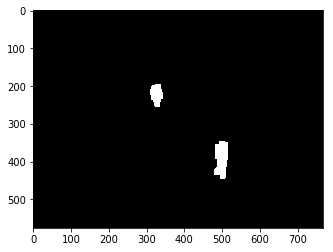

In [26]:
kernel = np.ones((7,7),np.uint8)
img_erosada = cv.erode(result,kernel,iterations = 1)
img_dilatada = cv.dilate(img_erosada,kernel,iterations = 2)


plt.imshow(np.uint8(img_dilatada))
plt.show()

## Contagem de pessoas

Para fazer a contagem de pessoas foi usada a função SimpleBlobDetector do opencv. Ela conta agrupacoes da mesma cor. Usando os parametros pôde-se especificar para a função apenas procurar blobs alongadas (que podem parecer pessoas)

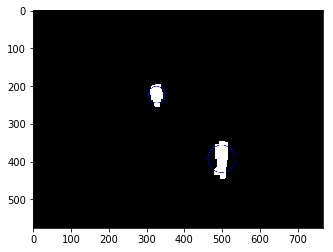

Foram achadas 2 pessoas


In [27]:


# Setup dos parametros
params = cv.SimpleBlobDetector_Params()
 
# params.minThreshold = 10;
# params.maxThreshold = 200;
 
params.filterByArea = False
# params.minArea = 40
 
params.filterByCircularity = False
# params.minCircularity = 0.1
 
params.filterByConvexity = False
# params.minConvexity = 0.87

params.filterByInertia = False
# params.minInertiaRatio = 0.01
 
# Cria o detector
ver = (cv.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv.SimpleBlobDetector(params)
else : 
    detector = cv.SimpleBlobDetector_create(params)


# detectando os blobs.
keypoints = detector.detect(255-np.uint8(img_dilatada))
 
# desenhando circulos nos blobs detectados.
im_with_keypoints = cv.drawKeypoints(np.uint8(img_dilatada), keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
plt.imshow(np.uint8(im_with_keypoints))
plt.show()
print("Foram achadas {0} pessoas".format(len(keypoints)))

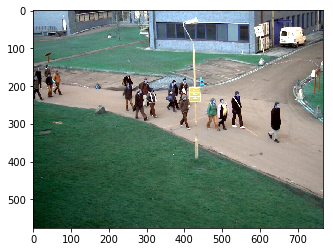

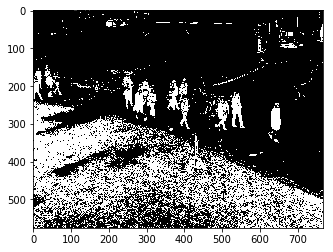

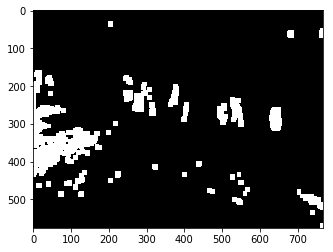

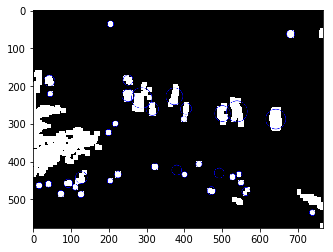

Foram achadas 36 pessoas


In [30]:

#Teste com 1 imagem de foreground mais dificil, uma multidao

img_teste = cv.imread(("../img/Crowd_PETS09-2/S1/L1//Time_13-59/View_001/frame_0122.jpg"))



rows, cols, cor = img_teste.shape

#Cria imagem preta
result = np.zeros((rows,cols,3))


for j in range(cols):
    for i in range(rows):
        if (codebook_check(img_teste[i][j].astype(float), codebook_matrix[i][j]) == False):
            result[i][j] = [255,255,255]
plt.imshow(np.uint8(img_teste))
plt.show()
plt.imshow(np.uint8(result))
plt.show()

kernel = np.ones((7,7),np.uint8)
img_erosada = cv.erode(result,kernel,iterations = 1)
img_dilatada = cv.dilate(img_erosada,kernel,iterations = 2)


plt.imshow(np.uint8(img_dilatada))
plt.show()

# detectando os blobs.
keypoints = detector.detect(255-np.uint8(img_dilatada))
 
# desenhando circulos nos blobs detectados.
im_with_keypoints = cv.drawKeypoints(np.uint8(img_dilatada), keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
plt.imshow(np.uint8(im_with_keypoints))
plt.show()
print("Foram achadas {0} pessoas".format(len(keypoints)))

# Conclusão

Para imagens simples, com poucas pessoas ele funciona bem, porém ainda nao está muito bom para multidões.